The following approach was original inspired by this [tutorial](https://www.youtube.com/watch?v=FB5EdxAGxQg&ab_channel=codebasics) - however it was later realized that due to the quadratic time complexity the [sklearn.svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) may not be right for our project, since it does not support Stochastic Gradient Descent using batches.

##**Loading the dataset**

In [1]:
import torchvision.transforms as transforms
import torchvision
import torch
from random import seed
seed(40)
torch.manual_seed(40)

# Transformations applied to images as they are loaded by the Pytorch dataloader
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

#where we'll store the data
google_drive_path = './drive/MyDrive/Colab Notebooks/3337_Project'

#download our data 
trainset = torchvision.datasets.CIFAR10(root=google_drive_path, train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root=google_drive_path, train=False, download=True, transform=transform)
#the above code is really just used for DLing all data
#we still need to manually transform it (normalize it)
#and we still need to split it into training and testing data

#don't need these anymore
del trainset 
del testset

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./drive/MyDrive/Colab Notebooks/3337_Project/cifar-10-python.tar.gz to ./drive/MyDrive/Colab Notebooks/3337_Project
Files already downloaded and verified


##**Defining functions for loading the data**

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

np.random.seed(40)

def unpickle(file): #adapted from https://www.cs.toronto.edu/~kriz/cifar.html
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  datadict = unpickle(filename)
  X = datadict[b'data']
  Y = datadict[b'labels']
  X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
  Y = np.array(Y)
  return X, Y

def load_CIFAR10(ROOT): #adapted from tutorial #this splits the data into training and testing sets
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = ROOT + '/data_batch_%d'%(b,)
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)    
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(ROOT + '/test_batch')
  return Xtr, Ytr, Xte, Yte

##**Loading the data and preprocessing**

In [3]:
import pandas as pd
cifar10_dir = './drive/MyDrive/Colab Notebooks/3337_Project/cifar-10-batches-py' #changed

X_train_4D_unNorm, y_train, X_test_4D_unNorm, y_test = load_CIFAR10(cifar10_dir) #splits into training and testing sets

In [4]:
data = [X_train_4D_unNorm, y_train, X_test_4D_unNorm, y_test]
for each in data:
  print(each.shape)
#still need to reshape and normalize

(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)
(10000,)


In [5]:
#reshape the data
X_train_2D_unNorm = np.reshape(X_train_4D_unNorm, (X_train_4D_unNorm.shape[0],-1))
X_test_2D_unNorm = np.reshape(X_test_4D_unNorm, (X_test_4D_unNorm.shape[0],-1))

#now we don't need the 4D data anymore
del X_train_4D_unNorm
del X_test_4D_unNorm

In [6]:
#here we show that we successfully transformed the 4D set of images to a 2D set of images
#each column is named column,row,rgb
print(X_train_2D_unNorm.shape)
print(X_test_2D_unNorm.shape)

(50000, 3072)
(10000, 3072)


In [7]:
#now let's produce our pd.DataFrames

columnLabels = [] #we'll feed this to our pd.DataFrame to label each column for each image
for i in range(32):
  for j in range(32):
    for color in ['r','g','b']:
      columnLabels.append(str(i)+','+str(j)+','+color)

X_train_unNorm = pd.DataFrame(X_train_2D_unNorm, columns=columnLabels)
X_test_unNorm = pd.DataFrame(X_test_2D_unNorm, columns=columnLabels)

#don't need X_train_2D_unNorm or X_test_2D_unNorm anymore
del X_train_2D_unNorm
del X_test_2D_unNorm

###**Normalization**
We are told in the [sklearn.linear_model.SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier) that "For best results using the default learning rate schedule, the data should have zero mean and unit variance." so we will standardize using [sklearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

In [8]:
#let's standardize
from sklearn.preprocessing import StandardScaler
X_train = pd.DataFrame(StandardScaler().fit_transform(X_train_unNorm), columns=columnLabels)
#fit_transform uses one argument both to determine the mins and maxs (scaling params) and to do the transform
#to normalize our X_test, we want to use the mins and maxs from the train data, since it's such a bigger sample, so we'll do this normalization in steps, first we'll call fit on the training data, then we'll call transform on the test data
X_test = pd.DataFrame(StandardScaler().fit(X_train_unNorm).transform(X_test_unNorm), columns=columnLabels) 

##**Training/HyperParameter tuning**
Found this [discussion](https://stackoverflow.com/questions/24617356/sklearn-sgdclassifier-partial-fit) helpful. Note that the SGDClassifier parameter shuffle being set to True apparently does not actually produce shuffling. Shuffling was implemented witht he help of sklearn's utils module.




In [9]:
def trainModel(model, batches, epochs, x, y):
  from sklearn.utils import shuffle
  for eachEpoch in range(epochs):
    #shuffle the data
    x_shuffled, y_shuffled = shuffle(x,y)
    for batch in range(batches):
      startIndex = int(batch*len(x)/batches)
      endIndex = int((batch+1)*len(x)/batches)
      model.partial_fit(x_shuffled[startIndex:endIndex], y_shuffled[startIndex:endIndex], classes=np.unique(y))
  return model

In [10]:
#now we are ready to make our Support Vector Classifier (a type of support vector machine)
from sklearn.linear_model import SGDClassifier
import time

EPOCHS = [1, 10, 20, 40, 80]
BATCHES = [100, 50, 25, 10, 5]

tic=time.time()
#This part takes about 1 hour
ACCs_for_each_E = []
for E in EPOCHS:
  ACCs_for_each_B = []
  for B in BATCHES:
    model = SGDClassifier() #for each combination of E and B we make a new model
    model = trainModel(model, B, E, X_train, y_train) #we train that model
    ACCs_for_each_B.append(model.score(X_test, y_test)) #and we evaluate it and keep the accuracy
  ACCs_for_each_E.append(ACCs_for_each_B)
toc = time.time()
print("Training took " + str((toc-tic)/3600) +" hours")

Training took 1.0359436141120062 hours


###**Varying Batch size across different Epoch counts**

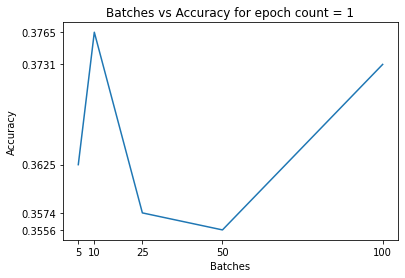

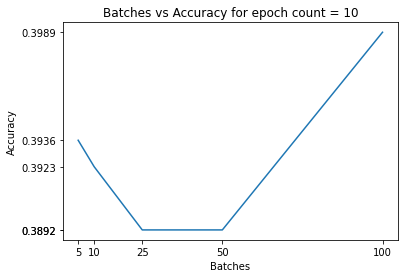

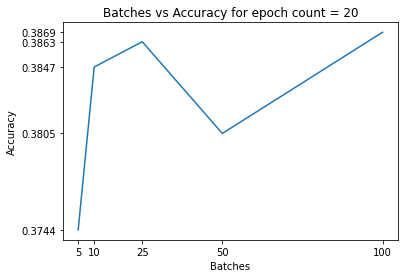

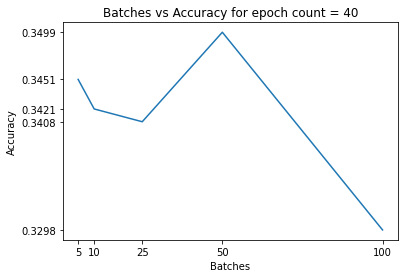

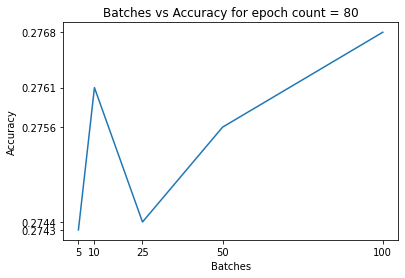

In [ ]:
import matplotlib.pyplot as plt
i = 0
for E in EPOCHS:
  plt.plot(BATCHES, ACCs_for_each_E[i])
  plt.xticks(BATCHES)
  plt.yticks(ACCs_for_each_E[i])
  plt.xlabel("Batches")
  plt.ylabel("Accuracy")
  plt.title(f"Batches vs Accuracy for epoch count = {E}")
  plt.show()
  i+=1


###**Varying Epoch counts across different Batch Sizes**




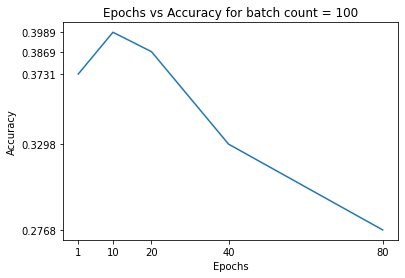

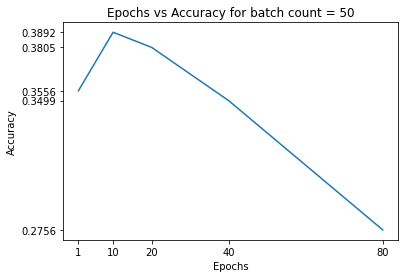

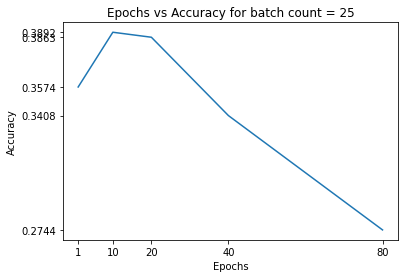

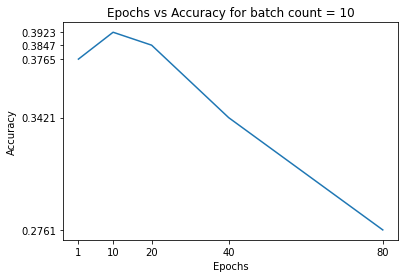

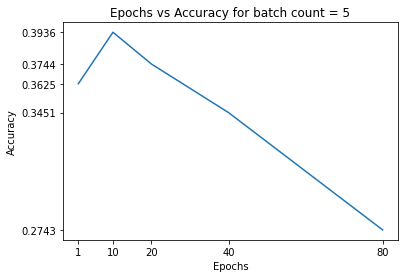

In [ ]:
#don't need to retrain and re-evaluate, just need the transpose of ACCs_for_each_E
ACCs_for_each_B = np.transpose(ACCs_for_each_E);
i = 0
for B in BATCHES:
  plt.plot(EPOCHS, ACCs_for_each_B[i])
  plt.xticks(EPOCHS)
  plt.yticks(ACCs_for_each_B[i])
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.title(f"Epochs vs Accuracy for batch count = {B}")
  plt.show()
  i+=1

###**Best Result from first tuning**

In [ ]:
best_i, best_j
max = ACCs_for_each_E[0][0]
for i in range(len(ACCs_for_each_E)):
  for j in range(len(ACCs_for_each_E[i])):
    if(ACCs_for_each_E[i][j] > max):
      max = ACCs_for_each_E[i][j]
      best_epoch = EPOCHS[i]
      best_batch = BATCHES[j]
print(f"the best accuracy was {max} which occured with Batch count = {best_batch} and Epoch count = {best_epoch}")


the best accuracy was 0.3989 which occured with Batch count = 100 and Epoch count = 10


##**Can we do better? (apparently not)**
Since the best epoch count was not a min or max of those tested, we can assume it's near an optimal count, but the best batch size was the highest tested, so could we increase it more for better performance? Let's find out!**bold text**

In [ ]:
EPOCHS = [5, 10, 15]
BATCHES = [100, 500, 1000]

ACCs_for_each_E = []
for E in EPOCHS:
  ACCs_for_each_B = []
  for B in BATCHES:
    model = SGDClassifier() #for each combination of E and B we make a new model
    model = trainModel(model, B, E, X_train, y_train) #we train that model
    ACCs_for_each_B.append(model.score(X_test, y_test)) #and we evaluate it and keep the accuracy
  ACCs_for_each_E.append(ACCs_for_each_B)

###**Varying Batch size across different Epoch counts**

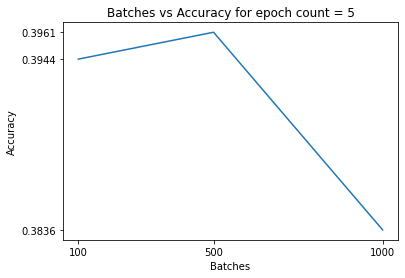

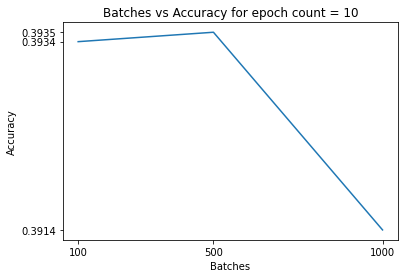

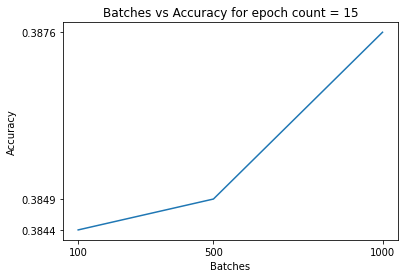

In [ ]:
i = 0
for E in EPOCHS:
  plt.plot(BATCHES, ACCs_for_each_E[i])
  plt.xticks(BATCHES)
  plt.yticks(ACCs_for_each_E[i])
  plt.xlabel("Batches")
  plt.ylabel("Accuracy")
  plt.title(f"Batches vs Accuracy for epoch count = {E}")
  plt.show()
  i+=1

###**Varying Epoch counts across different Batch Sizes**




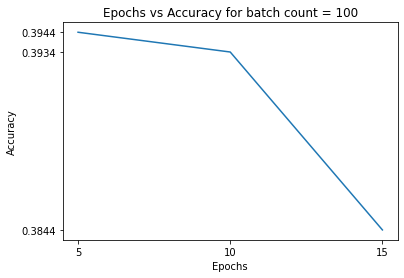

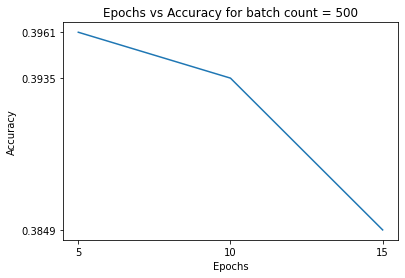

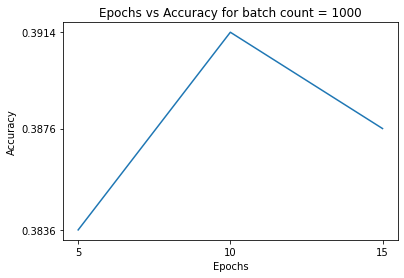

In [ ]:
#don't need to retrain and re-evaluate, just need the transpose of ACCs_for_each_E
ACCs_for_each_B = np.transpose(ACCs_for_each_E);
i = 0
for B in BATCHES:
  plt.plot(EPOCHS, ACCs_for_each_B[i])
  plt.xticks(EPOCHS)
  plt.yticks(ACCs_for_each_B[i])
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.title(f"Epochs vs Accuracy for batch count = {B}")
  plt.show()
  i+=1

###**Best Result from second tuning**

In [ ]:
best_i, best_j
max = ACCs_for_each_E[0][0]
for i in range(len(ACCs_for_each_E)):
  for j in range(len(ACCs_for_each_E[i])):
    if(ACCs_for_each_E[i][j] > max):
      max = ACCs_for_each_E[i][j]
      best_epoch = EPOCHS[i]
      best_batch = BATCHES[j]
print(f"the best accuracy was {max} which occured with Batch count = {best_batch} and Epoch count = {best_epoch}")

the best accuracy was 0.3961 which occured with Batch count = 500 and Epoch count = 5
